In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


No projector specified for this dataset. Please consider the method self.add_proj.


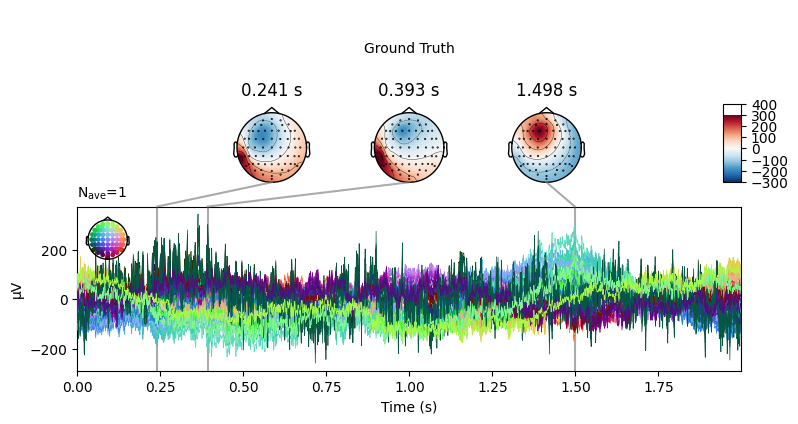

In [168]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=14,
    n_orders=(0, 0),
    snr_range=(1e99, 2e99),
    n_timecourses=200,
    n_timepoints=2000,
    amplitude_range=(1,1),
    scale_data=False)

gen = generator(fwd, **sim_params)

x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Algo

In [169]:
X = evoked.data
n_dipoles, n_time = X.shape

X -= X.mean(axis=0)

U, s, V = np.linalg.svd(X, full_matrices=False)
n_comps = np.where(s < s.mean())[0][0]
X_ = U[:, :n_comps].T @ X

X_1 = X_[:, :-1]
X_2 = X_[:, 1:]

# low rank-way
A = X_2 @ np.linalg.pinv(X_1)

# Symmetric Assumption
U_, S_, V_ = np.linalg.svd(A, full_matrices=False)
A = U_ @ V_.T

# RQ
from scipy.linalg import rq
R, Q = rq(X_1, mode="economic")


In [170]:
X_2_QT = X_2 @ Q.T
A = np.zeros((n_comps, n_comps))
for i in range(n_comps):
    print(i)
    A[i,i:] = X_2_QT[i, i:][np.newaxis, :] @ np.linalg.pinv(R)[i:, i:]

# X_2.shape

0
1
2
3
4
5
6


In [171]:
plt.figure()
plt.imshow(A)
timecourses = A @ X_

for i in range(n_comps):
    mne.viz.plot_topomap(U[:, :n_comps] @ A[:,i], info)
    plt.figure()
    plt.plot(timecourses[i])

In [184]:
from scipy.linalg import rq

def get_cov_causal(X):
    # U, s, V = np.linalg.svd(X, full_matrices=False)
    # n_comps = np.where(s < s.mean())[0][0]
    # X_ = U[:, :n_comps].T @ X

    X_1 = X[:, :-1]
    X_2 = X[:, 1:]

    R, Q = rq(X_1, mode="economic")
    X_2_QT = X_2 @ Q.T
    R_pinv = np.linalg.pinv(R)
    print(R.shape, Q.shape, R_pinv.shape)
    A = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        print(i)
        A[i,i:] = X_2_QT[i, i:][np.newaxis, :] @ R_pinv[i:, i:]
    # C = (U[:, :n_comps] @ A[:, :]) @ (U[:, :n_comps] @ A[:, :]).T
    T = A @ X
    
    return A, T

A,  timecourses = get_cov_causal(X)
plt.figure()
plt.imshow(A)

for i in range(n_comps):
    mne.viz.plot_topomap(C[i], info)
    plt.figure()
    plt.plot(timecourses[i])

(64, 64) (64, 1999) (64, 64)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
